In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [6]:
# Load a limited sample of the dataset
df = pd.read_csv('/content/drive/MyDrive/Full_Merged_AllCities_Energy_Weather.csv', nrows=50000)

# Parse datetime and set index
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df.set_index('time', inplace=True)

# Drop columns with all missing values
df.dropna(axis=1, how='all', inplace=True)
print(df.head(5))
print(df.columns)


                     generation biomass  generation fossil brown coal/lignite  \
time                                                                            
2014-12-31 23:00:00               447.0                                 329.0   
2014-12-31 23:00:00               447.0                                 329.0   
2014-12-31 23:00:00               447.0                                 329.0   
2014-12-31 23:00:00               447.0                                 329.0   
2014-12-31 23:00:00               447.0                                 329.0   

                     generation fossil coal-derived gas  \
time                                                      
2014-12-31 23:00:00                                 0.0   
2014-12-31 23:00:00                                 0.0   
2014-12-31 23:00:00                                 0.0   
2014-12-31 23:00:00                                 0.0   
2014-12-31 23:00:00                                 0.0   

                  

In [9]:
# Feature Engineering
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Month'] = df.index.month
df['DayOfWeek'] = df.index.dayofweek
df['DayOfYear'] = df.index.dayofyear
df['Sin_DayOfYear'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['Cos_DayOfYear'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
df['Lag_1'] = df['total load actual'].shift(1)
df['Lag_7'] = df['total load actual'].shift(7)
print(df.head(5))


                     generation biomass  generation fossil brown coal/lignite  \
time                                                                            
2014-12-31 23:00:00               447.0                                 329.0   
2014-12-31 23:00:00               447.0                                 329.0   
2014-12-31 23:00:00               447.0                                 329.0   
2014-12-31 23:00:00               447.0                                 329.0   
2014-12-31 23:00:00               447.0                                 329.0   

                     generation fossil coal-derived gas  \
time                                                      
2014-12-31 23:00:00                                 0.0   
2014-12-31 23:00:00                                 0.0   
2014-12-31 23:00:00                                 0.0   
2014-12-31 23:00:00                                 0.0   
2014-12-31 23:00:00                                 0.0   

                  

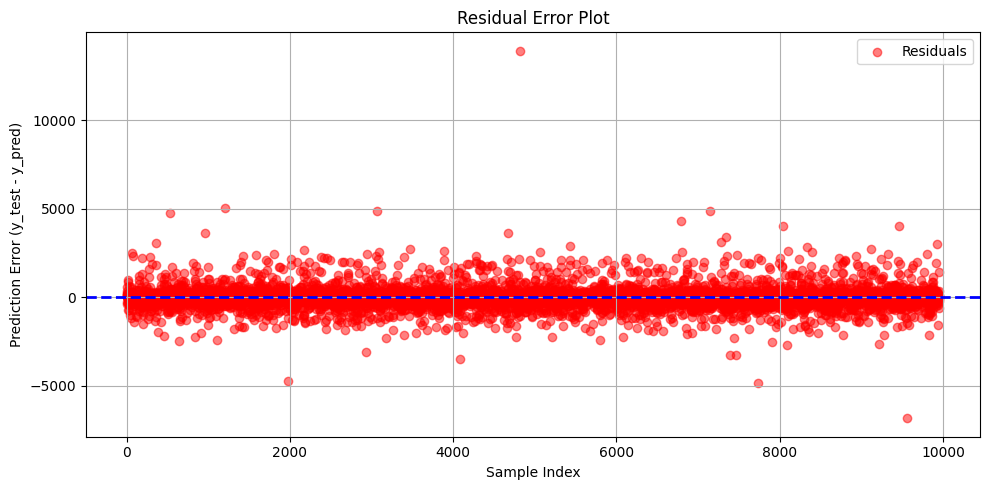

In [25]:
# Drop missing rows
target = 'total load actual'
features = ['Hour', 'Day', 'Month', 'DayOfWeek', 'DayOfYear', 'Sin_DayOfYear', 'Cos_DayOfYear',
            'Lag_1', 'Lag_7', 'temp', 'humidity', 'wind_speed', 'clouds_all']
df.dropna(subset=features + [target], inplace=True)

# Define input and output
X = df[features]
y = df[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 📉 Residual Error Plot
residuals = y_test - y_pred

plt.figure(figsize=(10, 5))
plt.scatter(range(len(residuals)), residuals, alpha=0.5, c='red', label='Residuals')
plt.axhline(y=0, color='blue', linestyle='--', linewidth=2)
plt.title('Residual Error Plot')
plt.xlabel('Sample Index')
plt.ylabel('Prediction Error (y_test - y_pred)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
# Predict and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

RMSE: 511.67
R² Score: 0.99


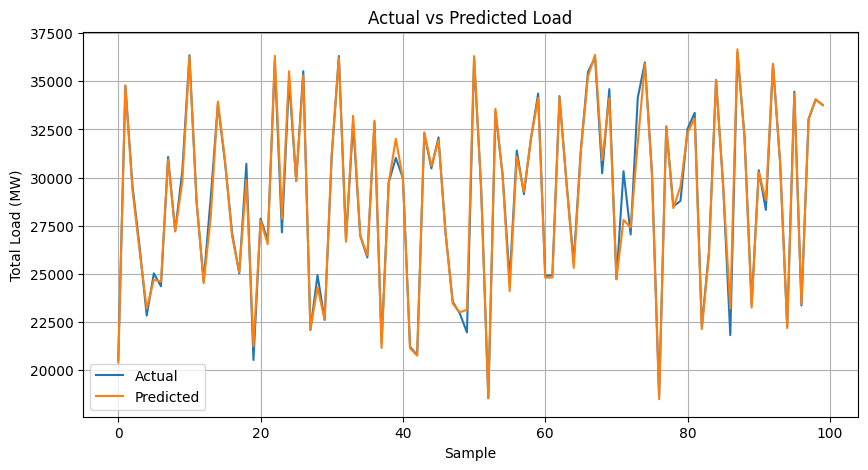

In [23]:
# Plot
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.title("Actual vs Predicted Load")
plt.xlabel("Sample")
plt.ylabel("Total Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# 🌲 Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

In [20]:
# Train XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

# Create results table
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'RMSE': [rf_rmse, xgb_rmse],
    'R² Score': [rf_r2, xgb_r2]
})
print(results_df)

           Model        RMSE  R² Score
0  Random Forest  511.669628  0.988187
1        XGBoost  447.678664  0.990957


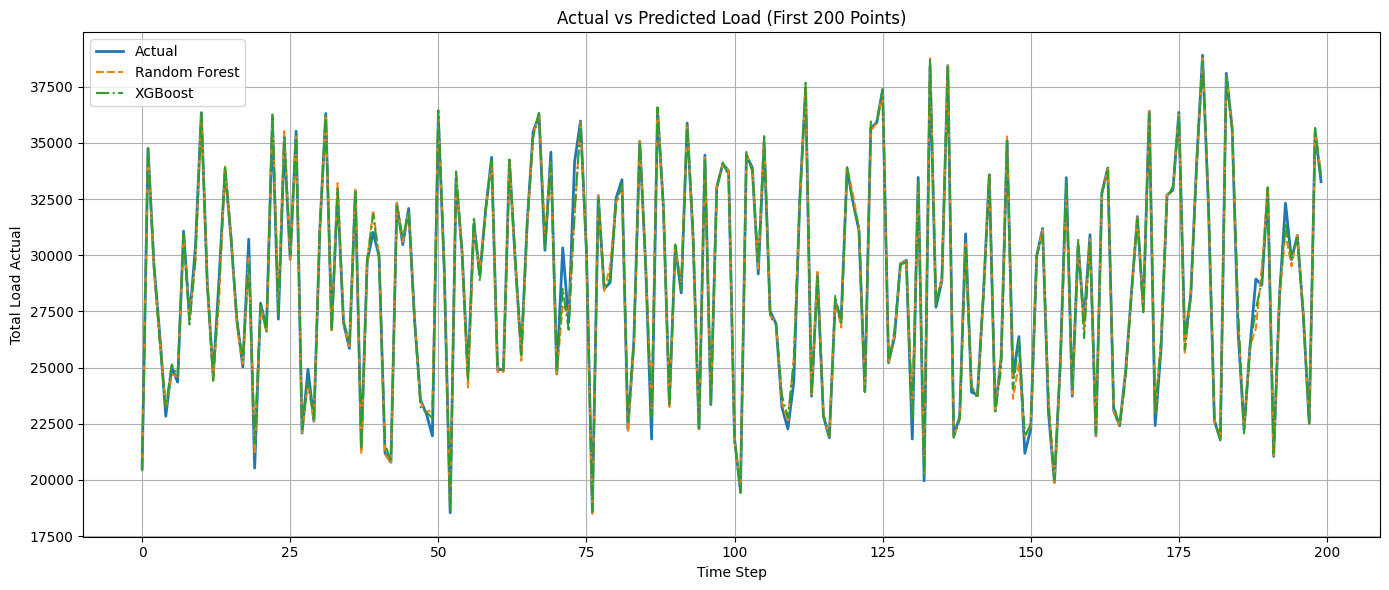

In [21]:
# Plot predictions
plt.figure(figsize=(14, 6))
plt.plot(y_test.values[:200], label='Actual', linewidth=2)
plt.plot(rf_pred[:200], label='Random Forest', linestyle='--')
plt.plot(xgb_pred[:200], label='XGBoost', linestyle='-.')
plt.title("Actual vs Predicted Load (First 200 Points)")
plt.xlabel("Time Step")
plt.ylabel("Total Load Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()